# Import packages

In [2]:
# -*- coding: utf-8 -*-

import datetime as dt
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas_datareader import data, wb
from scipy.optimize import minimize
from scipy.stats import norm


#  Data for portfolio and hedge securities

In [3]:
class Portfolio:
    """the hedge portoflio     """
        
    def __init__(self, pf_sec, hedge_sec, start, end , p_weight):
        """Return a portfolio object which contain securities *pf_sec* and hedge securities *hedge_sec*."""
        
        self.pf_sec =  pf_sec
        self.hedge_sec =  hedge_sec
        self.start = start
        self.end = end
        self.p_weight =   p_weight
    
        
        
    def port_rtn(self):
        """get portfolio returns"""
        
        data_p = data.DataReader(self.pf_sec,'google',start=self.start,end=self.end)['Close']           
        #portfolio price
        pf_p = np.sum(data_p*self.p_weight,axis=1)        
        #portfolio returns
        pf_rtn= pd.DataFrame(pf_p.pct_change().dropna() ,columns=['return'])        
        return pf_rtn
    
    def hedge_rtn(self):
        """get portfolio returns"""
        #hedge securities price
        hedge_p = data.DataReader(self.hedge_sec,'google',start=self.start,end=self.end)['Close']
        #hedge securities returns
        hedge_rtn = pd.DataFrame(hedge_p.pct_change().dropna())
        return hedge_rtn


In [4]:
class Hedge:
    
    """
    used for hedge purpose

    """ 
    
    def __init__(self,port_rtn, hedge_rtn, n, lambd):
        """optimize portfolio and generating hedge ratio for specified time period
        the formula for hedge is as following:
        P_final = Ret(portfolio) + lambda(hedge_ratio*hedge_securities)
        
        
        """
        
  
        #securieties to be hedged
        self.port_rtn = port_rtn
        
        # hedge securieties
        self.hedge_rtn = hedge_rtn
        
        # rolling base(hedge every n day)
        self.n =  n
        
        # lambda for hedge securities
        self.lambd = lambd
        self.num = self.hedge_rtn.shape[1]
        
    
    
    def by_VaR(self):  
        '''optimize based on VaR'''
        
        alpha=0.01
        
        
        # minimize fuction
        def min_VaR(h):    
            p = self.port_rtn['return']+np.dot(self.hedge_rtn,np.array(h))* self.lambd
            return norm.ppf(1-alpha)* np.std(p)-np.mean(p)        
        
        # bondary for hedge ratio
        bon = tuple((-2, 2) for i in range(self.num))
        
        # optimizarion
        res = minimize(min_VaR, tuple(0 for i in range(self.num)),
                    method='SLSQP',bounds=bon, options={'disp': True})

        return  res.x
    
    def by_cvar(self):  
        '''optimize based on cvar'''
        
        alpha=0.01
        
        # minimize fuction
        def min_cvar(h):  
            p = self.port_rtn['return']+ np.dot(self.hedge_rtn,np.array(h))* self.lambd
            return alpha**-1*norm.pdf(norm.ppf(alpha))*np.std(p)-np.mean(p)
        
        # bondary for hedge ratio
        bon = tuple((-2, 2) for i in range(self.num))
        
        # optimizarion
        res = minimize(min_cvar, tuple(0 for i in range(self.num)),
                    method='SLSQP',bounds=bon, options={'disp': True})

        return  res.x
    
    def by_std(self):  
        '''optimize based on std'''
        
        # minimize fuction
        def min_std(h):  
            p = self.port_rtn['return']+ np.dot(self.hedge_rtn,np.array(h))* self.lambd
            return np.std(p)
        # bondary for hedge ratio
        bon = tuple((-2, 2) for i in range(self.num))
        
        # optimizarion
        res = minimize(min_std, tuple(0 for i in range(self.num)),
                    method='SLSQP',bounds=bon, options={'disp': True})
        return  res.x
    
      
    def roll(self,method,n, rf,pl):
        
        ratio_data = []
        return_data_h = []
        return_data_uh = []
        sharpe_ratio_h = []
        sharpe_ratio_uh = []
        var_data_h = []
        var_data_uh = []
        VaR_data_h = []
        VaR_data_uh = []
        CVaR_data_h = []
        CVaR_data_uh = []
        
        
        print 'Processing....'
        for i in xrange (0,n):
            r_pf=self.port_rtn['return'][i:i+5]
            r_hedge=self.hedge_rtn[i:i+5]
            
            if method == 'VaR':
                alpha=0.01
                def VaR(h):
                    p = r_pf+ np.dot(r_hedge,np.array(h))* self.lambd
                    return norm.ppf(1-alpha)* np.std(p)-np.mean(p)
                # bondary for hedge ratio
                bon = tuple((-2, 2) for i in range(self.num))
                res = minimize(VaR, tuple(0 for i in range(self.num)), 
                               method='SLSQP',bounds=bon, options={'disp': False})       
        
                          
            elif method == 'cvar':
                alpha=0.01
                def cvar(h):  
                    p = r_pf+ np.dot(r_hedge,np.array(h)) * self.lambd
                    return alpha**-1*norm.pdf(norm.ppf(alpha))*np.std(p)-np.mean(p)  
                # bondary for hedge ratio
                bon = tuple((-2, 2) for i in range(self.num))
                res = minimize(cvar, tuple(0 for i in range(self.num)),
                    method='SLSQP',bounds=bon, options={'disp': False})
                         
            elif method == 'std':
                def std(h):
                    return np.std(r_pf+np.dot(r_hedge,np.array(h))* self.lambd)
                # bondary for hedge ratio
                bon = tuple((-2, 2) for i in range(self.num))
                res = minimize(std, tuple(0 for i in range(self.num)),
                    method='SLSQP',bounds=bon, options={'disp': False})
            
            else:
                break       
          
            # return using last day data


            ret_h = (r_pf+ np.dot(r_hedge,np.array(res.x)) * self.lambd)[4]
            ret_uh = r_pf[4]
            
            portfolio_info = r_pf+ np.dot(r_hedge,np.array(res.x)) * self.lambd
            
            
            # sharpe ratio
            sp_h= (np.mean(portfolio_info)-rf)/np.std(portfolio_info)
            sp_uh= (np.mean(r_pf)-rf)/np.std(r_pf)
            
            # variance
            var_h= np.var(portfolio_info)
            var_uh= np.var(r_pf)
            
            # VaR
            alpha=0.01
            VaR_h = norm.ppf(1-alpha)* np.std(portfolio_info)-np.mean(portfolio_info)
            VaR_uh = norm.ppf(1-alpha)* np.std(r_pf)-np.mean(r_pf)
            
            # CVaR
            CVaR_h = alpha**-1*norm.pdf(norm.ppf(alpha))*np.std(portfolio_info)-np.mean(portfolio_info)
            CVaR_uh = alpha**-1*norm.pdf(norm.ppf(alpha))*np.std(r_pf)-np.mean(r_pf)
            
            
            

            return_data_h.append(ret_h)
            return_data_uh.append(ret_uh)
            ratio_data.append(res.x)
            sharpe_ratio_h.append(sp_h)
            sharpe_ratio_uh.append(sp_uh)
            var_data_h.append(var_h)
            var_data_uh.append(var_uh)
            VaR_data_h.append(VaR_h)
            VaR_data_uh.append(VaR_uh)
            CVaR_data_h.append(CVaR_h)
            CVaR_data_uh.append(CVaR_uh)
            
            
            
            i=i+1
            
        ratio_data = pd.DataFrame(ratio_data,columns=list(self.hedge_rtn.columns))
        return_data_uh = pd.DataFrame(return_data_uh,columns=['unhedged'])
        return_data_h = pd.DataFrame(return_data_h,columns=['hedged'])
        return_data = pd.concat([return_data_h, return_data_uh], axis=1)
        
        sharpe_ratio_uh = pd.DataFrame(sharpe_ratio_uh,columns=['unhedged'])
        sharpe_ratio_h = pd.DataFrame(sharpe_ratio_h,columns=['hedged'])
        sharpe_ratio = pd.concat([sharpe_ratio_h, sharpe_ratio_uh], axis=1)
        
        var_data_uh = pd.DataFrame(var_data_uh,columns=['unhedged'])
        var_data_h = pd.DataFrame(var_data_h,columns=['hedged'])
        var_data = pd.concat([var_data_h, var_data_uh], axis=1)
        
        VaR_data_uh = pd.DataFrame(VaR_data_uh,columns=['unhedged'])
        VaR_data_h = pd.DataFrame(VaR_data_h,columns=['hedged'])
        VaR_data = pd.concat([VaR_data_h, VaR_data_uh], axis=1)
        
        CVaR_data_uh = pd.DataFrame(CVaR_data_uh,columns=['unhedged'])
        CVaR_data_h = pd.DataFrame(CVaR_data_h,columns=['hedged'])
        CVaR_data = pd.concat([CVaR_data_h, CVaR_data_uh], axis=1)
        
        
        
               
        cumulative_return_uh =  (return_data_uh+ 1).cumprod() - 1
        cumulative_return_h =  (return_data_h+ 1).cumprod() - 1
        cumulative_return_uh.columns = ['unhedged']
        cumulative_return_h.columns = ['hedged']
        cumulative_return = pd.concat([cumulative_return_h, cumulative_return_uh], axis=1)
        
        #+++++test++++
        #print sharpe_ratio
        #print ratio_data
        #print return_data
        #print cumulative_return
        #++++++++++++++
        
        
        # choose what value you want to see on final graph

        if pl == 'all':
            ratio_data.plot(title = 'hedge ratio'+' by using '+str(method))

            #return_data_h.plot(title = str(method)+' return')
            #return_data_uh.plot(title = str(method)+' return')
            return_data.plot(title = 'return'+' by using '+str(method))

            #cumulative_return_uh.plot(title = str(method)+' cumulative return')
            #cumulative_return_h.plot(title = str(method)+' cumulative return')
            cumulative_return.plot(title = 'cumulative return'+' by using '+str(method))

            #sharpe_ratio_h.plot(title = str(method)+'  Sharpe ratio')
            #sharpe_ratio_uh.plot(title = str(method)+'  Sharpe ratio')
            sharpe_ratio.plot(title = 'Sharpe ratio'+' by using '+str(method))

            var_data.plot(title = 'variance'+' by using '+str(method))

            VaR_data.plot(title = 'VaR'+' by using '+str(method))

            CVaR_data.plot(title = 'CVaR'+' by using '+str(method))
            return cumulative_return_h
        elif pl == 'VaR':
            VaR_data.plot(title = 'VaR'+' by using '+str(method))
            VaR_data_h.columns=[str(method)]
            return VaR_data_h
        elif pl == 'var':
            var_data.plot(title = 'variance'+' by using '+str(method))
            var_data_h.columns=[str(method)]
            return var_data_h
        elif pl == 'cvar':
            CVaR_data.plot(title = 'CVaR'+' by using '+str(method))
            CVaR_data_h.columns=[str(method)]
            return CVaR_data_h
        elif pl == 'cumulative':
            cumulative_return.plot(title = 'cumulative return'+' by using '+str(method))
            cumulative_return_h.columns=[str(method)]
            return cumulative_return_h
        
        
    


    
        
        
        
    
 

# +++++++++++++++++++++++++++++++++++++++++++++++++++++

# test here

# +++++++++++++++++++++++++++++++++++++++++++++++++++++

# portfolio

In [239]:


# ++++++++++++++++++++  Change default setting here ++++++++++++++++++    
sec = ['ms','pfk','blk','cs','gs','ice','met','kcg','apo','fig']   
h_sec = ['spy','iyf','csj']
start = dt.datetime(2016,1,1)  
end = dt.datetime(2016,12,31) 
portfolio_weight =  [1./len(sec) for i in sec] 

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# set up data gathering class and gather data
default_portfolio = Portfolio(sec,h_sec,start,end,portfolio_weight)

# return for hedge securities
hedge_rtn =  default_portfolio.hedge_rtn()

# return for securities to be hedged
port_rtn = default_portfolio.port_rtn()

op = Hedge(port_rtn,hedge_rtn,n=1,lambd = 1)   

# bonds

In [121]:

# ++++++++++++++++++++  Change default setting here ++++++++++++++++++    
sec = ['lqd']   
h_sec = ['tlo']
start = dt.datetime(2016,1,1)  
end = dt.datetime(2016,12,31) 
portfolio_weight =  [1./len(sec) for i in sec] 

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# set up data gathering class and gather data
default_portfolio = Portfolio(sec,h_sec,start,end,portfolio_weight)

# return for hedge securities
hedge_rtn =  default_portfolio.hedge_rtn()

# return for securities to be hedged
port_rtn = default_portfolio.port_rtn()

op = Hedge(port_rtn,hedge_rtn,n=1,lambd = 1)   

# inflation

## gold

In [21]:
start = dt.datetime(2006,1,1)  
end = dt.datetime(2016,12,31) 

cpi=data.DataReader('CPIAUCSL','fred', start, end )
gold=data.DataReader('GOLDAMGBD228NLBM','fred', start , end )
df = pd.concat([cpi,gold],axis=1)
df['GOLDAMGBD228NLBM']=df['GOLDAMGBD228NLBM'].fillna(method='pad')
df=df.dropna()
df=df.pct_change().dropna()
###df = pd.concat([cpi,gold],axis=1).pct_change().dropna()
df.columns = ['return','gold']

# return for hedge securities
hedge_rtn =  pd.DataFrame(df['gold'])

# return for securities to be hedged
port_rtn = pd.DataFrame(df['return'])

op = Hedge(port_rtn,hedge_rtn,n=1,lambd = 1)  
corgold=np.correlate(df['return'],df['gold'])

## tips

In [22]:
start = dt.datetime(2006,1,1)  
end = dt.datetime(2016,12,31) 

cpi=data.DataReader('CPIAUCSL','fred', start, end )
tip=data.DataReader('tip','google', start , end )['Close']
df = pd.concat([cpi,tip],axis=1)
df['Close']=df['Close'].fillna(method='pad')
df=df.dropna()
df=df.pct_change().dropna()
##df = pd.concat([cpi,tip],axis=1).pct_change().dropna()
df.columns = ['return','tip']

# return for hedge securities
hedge_rtn =  pd.DataFrame(df['tip'])

# return for securities to be hedged
port_rtn = pd.DataFrame(df['return'])

op = Hedge(port_rtn,hedge_rtn,n=1,lambd = 1)   
cortips=np.correlate(df['return'],df['tip'])


# spy

In [23]:

start = dt.datetime(2006,1,1)  
end = dt.datetime(2016,12,31) 

cpi=data.DataReader('CPIAUCSL','fred', start, end )
spy=data.DataReader('spy','google', start , end )['Close']
df = pd.concat([cpi,spy],axis=1)
df['Close']=df['Close'].fillna(method='pad')
df=df.dropna()
df=df.pct_change().dropna()
#df = pd.concat([cpi,spy],axis=1).pct_change().dropna()
df.columns = ['return','spy']

# return for hedge securities
hedge_rtn =  pd.DataFrame(df['spy'])

# return for securities to be hedged
port_rtn = pd.DataFrame(df['return'])

op = Hedge(port_rtn,hedge_rtn,n=1,lambd = 1)      
corspy=np.correlate(df['return'],df['spy'])


In [24]:
port_rtn.shape

(130, 1)

In [25]:
op.by_VaR()
op.by_cvar()
op.by_std()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00549000385695
            Iterations: 3
            Function evaluations: 9
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00649288802897
            Iterations: 3
            Function evaluations: 9
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00295652798265
            Iterations: 3
            Function evaluations: 9
            Gradient evaluations: 3


array([-0.02877742])

# graph for hedge ratio change over month

period 126
Processing....
Processing....
Processing....


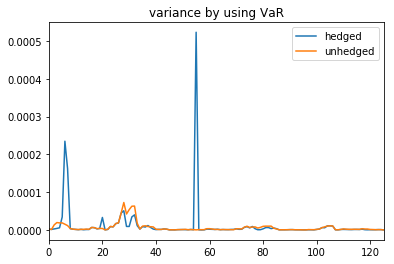

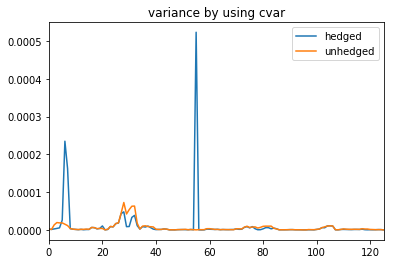

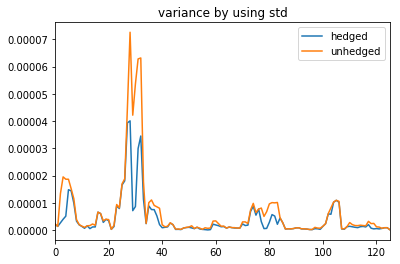

In [26]:
#n = 5  # number of day or number of month (test)
n = port_rtn.shape[0]-5+1  # number of day or number of month (all data)
print 'period',n
rf = 0.1/365
pl='var'   # 'all','var', 'cvar', 'VaR', 'cumulative'
total = pd.concat([op.roll('VaR',n,rf,pl),op.roll('cvar',n,rf,pl),op.roll('std',n,rf,pl)], axis=1)


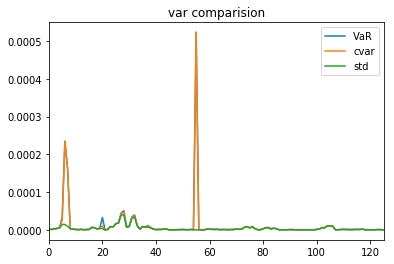

In [27]:
# change return value if you want to see graph rather than culmulative return
total.plot(title = str(pl)+' comparision')

In [28]:

print corgold,cortips,corspy

[ 0.00755113] [ 0.00242455] [ 0.00834682]


# +++++++++++++++++++++++++++++++++++++++++++++++++++++